# Use Case 6: Comparing Derived Molecular Data with Proteomics


For this use case, we will be looking at the derived molecular data contained in the Endometrial dataset, and comparing it with protein data. Derived molecular data means that we created new variables based on molecular data. One example of this is the activity of a pathway based on the abundance of phosphorylation sites. A second example is inferred cell type percentages from algorithms like CIBERSORT, which are based on comparing transcriptomics data to known profiles of pure cell types. 

## Step 1: Importing packages

We will start by importing the python packages we will need, including the CPTAC Endometrial data package, which includes the Endometrial patient data as well as accessory functions that we will use to analyze the data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import CPTAC.Endometrial as en

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


## Step 2: Getting data and selecting attributes

For this use case, we will be using two dataframes contained in the Endometrial dataset: <code>derived_molecular</code> and <code>proteomics</code>. We will use the getter functions to store these dataframes in variables.

In [3]:
der_molecular = en.get_derived_molecular()
proteomics = en.get_proteomics()

The derived molecular dataframe contains many different attributes that we can choose from for analysis. To view a list of these attributes, we can print out the column names of the dataframe. To view the full list of column names without truncation, first use the command <code>pd.set_option('display.max_seq_items', None)</code>.


In [13]:
der_molecular.columns.tolist()

['Proteomics_TMT_batch',
 'Proteomics_TMT_plex',
 'Proteomics_TMT_channel',
 'Proteomics_Parent_Sample_IDs',
 'Proteomics_Aliquot_ID',
 'Proteomics_OCT',
 'Estrogen_Receptor',
 'Estrogen_Receptor_%',
 'Progesterone_Receptor',
 'Progesterone_Receptor_%',
 'MLH1',
 'MLH2',
 'MSH6',
 'PMS2',
 'p53',
 'Other_IHC_specify',
 'MLH1_Promoter_Hypermethylation',
 'EPIC_Bcells',
 'EPIC_CAFs',
 'EPIC_CD4_Tcells',
 'EPIC_CD8_Tcells',
 'EPIC_Endothelial',
 'EPIC_Macrophages',
 'EPIC_NKcells',
 'EPIC_otherCells',
 'CIBERSORT_B _cells _naive',
 'CIBERSORT_B _cells _memory',
 'CIBERSORT_Plasma _cells',
 'CIBERSORT_T _cells _CD8',
 'CIBERSORT_T _cells _CD4 _naive',
 'CIBERSORT_T _cells _CD4 _memory _resting',
 'CIBERSORT_T _cells _CD4 _memory _activated',
 'CIBERSORT_T _cells _follicular _helper',
 'CIBERSORT_T _cells _regulatory _(Tregs)',
 'CIBERSORT_T _cells _gamma _delta',
 'CIBERSORT_NK _cells _resting',
 'CIBERSORT_NK _cells _activated',
 'CIBERSORT_Monocytes',
 'CIBERSORT_Macrophages _M0',
 'CIBE

For our purposes, we are going to be comparing MSI status with the JAK1 protein abundance. MSI stands for <a href="https://en.wikipedia.org/wiki/Microsatellite_instability">Microsatellite instability</a>. The possible values for MSI status are MSI-H (high microsatellite instability) or MSS (microsatellite stable). In this context, "nan" refers to non-tumor samples. To see all of the possible values in any column, you can use the pandas function <code>.unique()</code>

In [5]:
der_molecular['MSI_status'].unique()

array(['MSI-H', 'MSS', nan], dtype=object)

## Step 3: Merge dataframes

We will use the <code>en.compare_derived_molecular()</code> function to merge our desired molecular trait with the proteomics data.  

In [6]:
merged_data = en.compare_derived_molecular(omics_data=proteomics, molecular_col='MSI_status')

## Step 4: Plot data

Now we will use the seaborn and matplotlib libraries to create a boxplot and histogram that will allow us to visualize this data. For more information on using seaborn, see <a href="https://seaborn.pydata.org/tutorial.html">seaborn tutorial</a>.

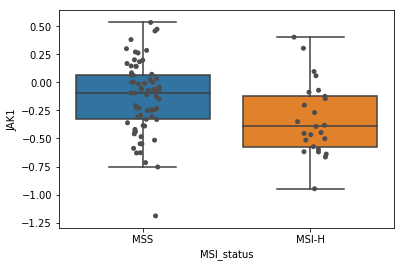

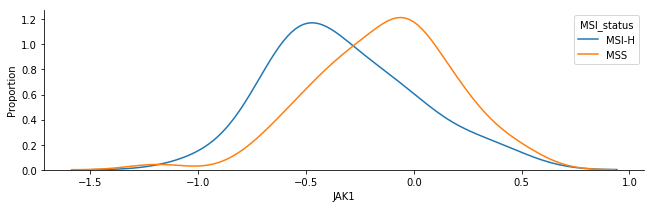

In [12]:
msi_boxplot = sns.boxplot(x='MSI_status', y='JAK1', data = merged_data, showfliers = False, order = ['MSS', 'MSI-H'])
msi_boxplot = sns.stripplot(x='MSI_status', y='JAK1', data = merged_data, color = '.3', order = ['MSS', 'MSI-H'])
plt.show()

msi_histogram = sns.FacetGrid(merged_data[['MSI_status', 'JAK1']], hue="MSI_status", legend_out=False, aspect = 3)
msi_histogram = msi_histogram.map(sns.kdeplot, "JAK1").add_legend(title="MSI_status")
msi_histogram.set(ylabel='Proportion')
plt.show()